# 🎮 1D Playground: Diffusion & Flow Matching Sanity Checks

This notebook provides interactive 1D experiments to build intuition for diffusion models and flow matching.

**Why 1D?**
- Ultra-fast training (in seconds & CPU friendly)
- Easy to visualize distributions and flows
- Perfect for debugging and understanding

**Note:** You should be able to use this notebook with CPU only machines.

If you are using VSCode and you do not see your venv in the kernel options, first activate your venv in your terminal and run 

'''

uv run --active python -m ipykernel install --user --name cmu-10799 --display-name "Python (cmu-10799)"

'''

In VS Code:
- Command Palette → Python: Select Interpreter → pick .venv-(your env)/bin/python
- In the notebook → Select Kernel → pick .venv-(your env) or Python (cmu-10799-cpu)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Create 1D Mixture of Gaussians

In [8]:
def get_1d_data(name, n_samples=10000):
    """Generate 1D mixture of Gaussians datasets with different weights."""
    if name == '2gaussians':
        # Two Gaussians at -2 and 2 (equal weights)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        # Three Gaussians at -2, 0, 2 (equal weights)
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        # Five evenly spaced Gaussians (equal weights)
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        # Uneven mixture with different spacing (equal weights)
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        # Wider Gaussians (equal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        # Two Gaussians with different weights (tall left, short right)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        # Three Gaussians with different weights (tall-short-medium)
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        # Five Gaussians with varied weights
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        # Wider Gaussians (unequal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Sample from each Gaussian according to weights
    X = []
    for center, weight in zip(centers, weights):
        n_samples_for_center = int(n_samples * weight)
        samples = np.random.randn(n_samples_for_center, 1) * std + center
        X.append(samples)
    X = np.concatenate(X, axis=0)
    
    # Shuffle
    np.random.shuffle(X)
    
    return torch.tensor(X, dtype=torch.float32)


def get_ground_truth_density(name, x_values):
    """Compute the ground truth density for a given dataset at x_values."""
    if name == '2gaussians':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Compute mixture of Gaussians density
    density = np.zeros_like(x_values)
    for center, weight in zip(centers, weights):
        density += weight * (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - center) / std) ** 2)
    
    return density

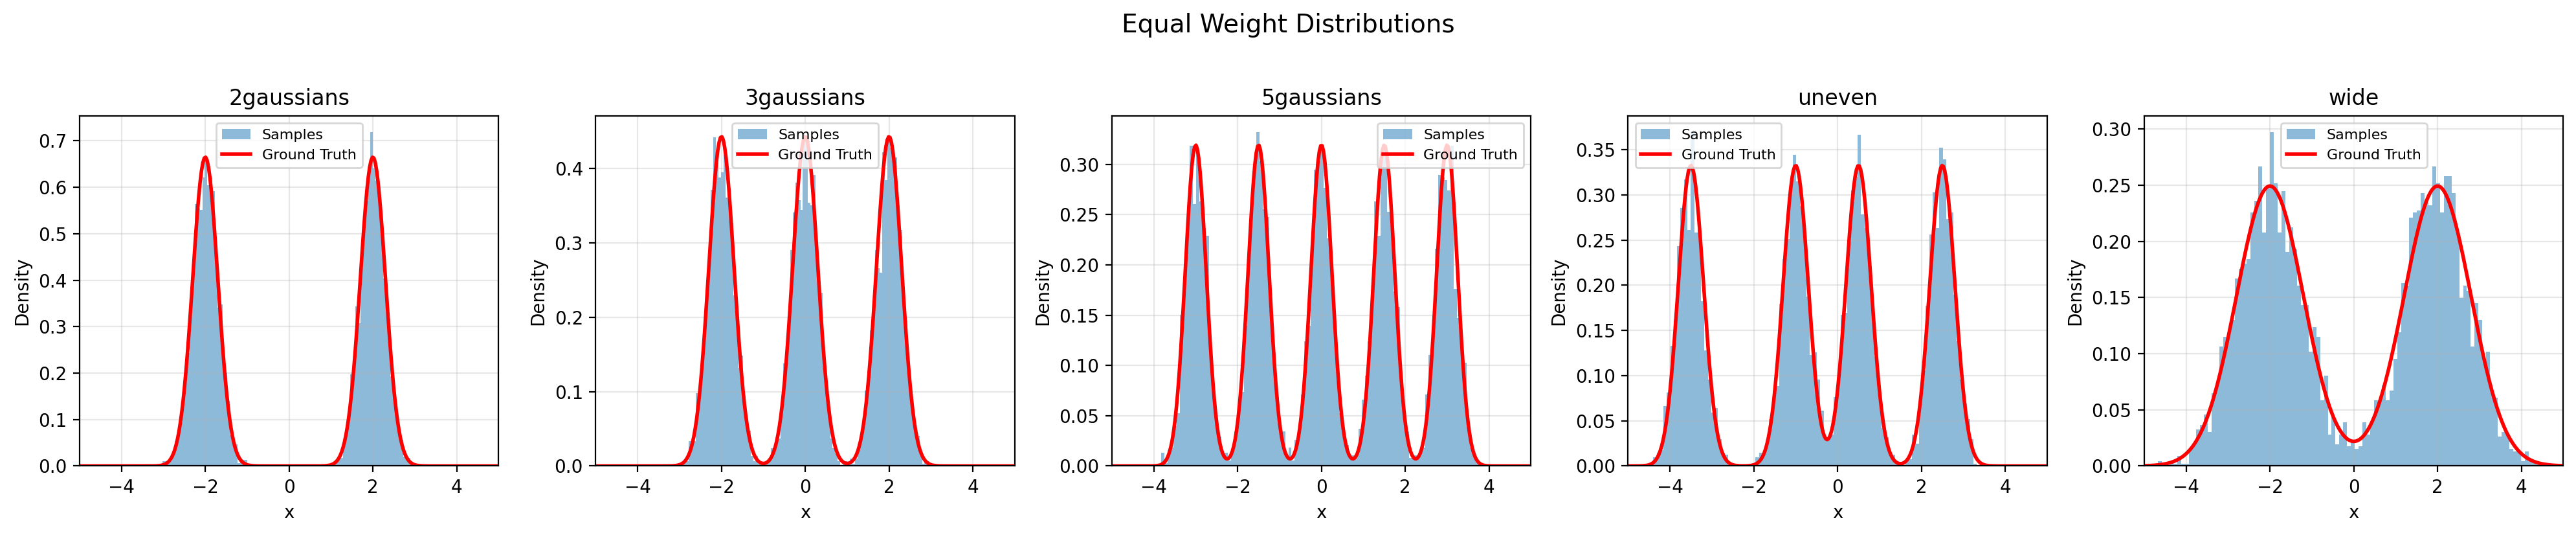

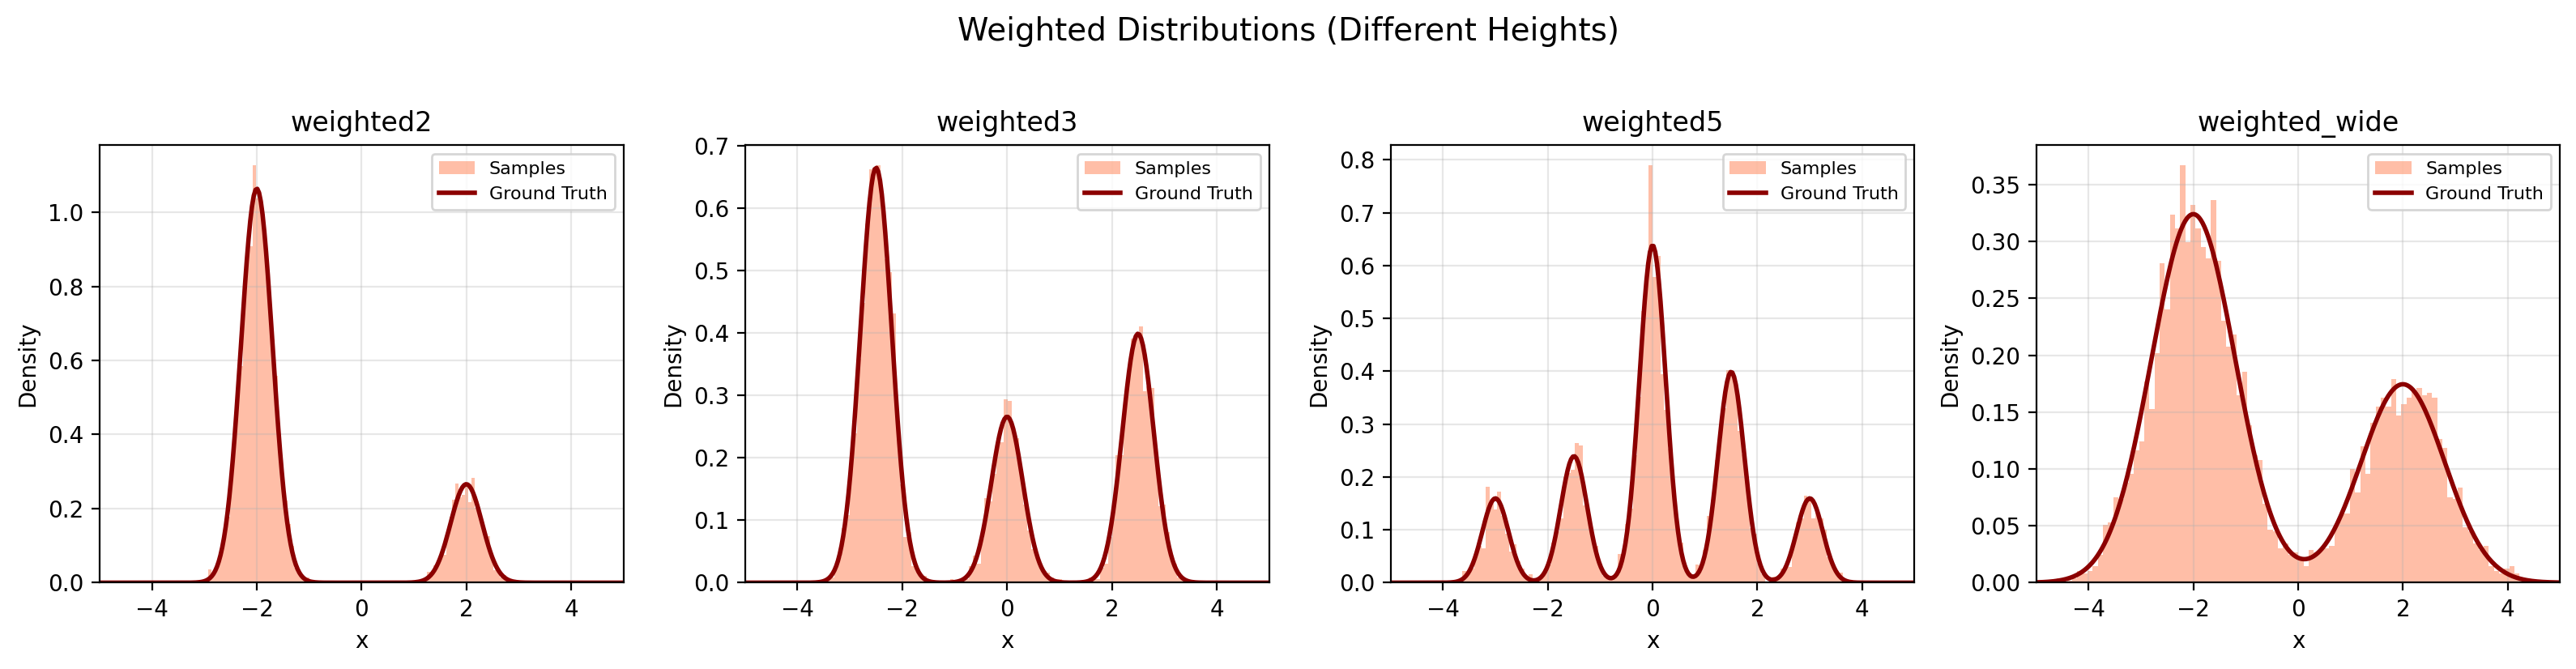

In [9]:
# Visualize available distributions
datasets_equal = ['2gaussians', '3gaussians', '5gaussians', 'uneven', 'wide']
datasets_weighted = ['weighted2', 'weighted3', 'weighted5', 'weighted_wide']

# Plot equal weight distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Equal Weight Distributions', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_equal):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'r-', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Plot weighted distributions
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Weighted Distributions (Different Heights)', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_weighted):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, color='coral', label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'darkred', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## 2. Simple network for 1D

First design a simple network (like an MLP) to model the 1D data, remember to also include the time embeddings.

In [10]:
class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        t=t.float()
        half_dim=self.embedding_dim//2
        i=torch.arange(0,half_dim,dtype=torch.float32)
        w_i=torch.exp(-i/half_dim*torch.log(torch.tensor(10000.0)))
        #dimension transformation
        t=t[:,None]
        w_i=w_i[None,:]
        arg=t*w_i
        emb=torch.cat((torch.sin(arg),torch.cos(arg)),dim=-1)
        return emb

class MLP(nn.Module):
    def __init__(self, data_dim, time_dim, hidden_dim, output_dim):
        super().__init__()
        self.data_dim = data_dim
        self.time_dim = time_dim
        self.time_emb = TimeEmbedding(time_dim)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(data_dim + time_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t):
        x = x.view(x.shape[0], -1)
        emb = self.time_emb(t)
        x = self.fc1(torch.cat([x, emb], dim=-1))
        x = F.relu(x)
        x = self.fc2(x)
        return x

## 3. DDPM algorithm implementation

Implement the forward process, backward process, loss calculation and the sampling process of the DDPM algorithm. You can feel free to follow the structure of src/methods/ddpm.py or directly import your implementation from there.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DDPM1D(nn.Module):
    def __init__(self, model, device, num_timesteps, beta_start, beta_end):
        super().__init__()
        self.model = model
        self.device = device
        self.num_timesteps = num_timesteps
        
        # Precompute schedules and register as buffers (moves to device with the model)
        betas = torch.linspace(beta_start, beta_end, num_timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas', torch.sqrt(alphas))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))
        self.register_buffer('recip_sqrt_alphas', torch.sqrt(1.0 / alphas))

    def q_sample(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        
        view_shape = (x_0.shape[0],) + (1,) * (x_0.dim() - 1)
        
        # Extract coefficients and reshape for broadcasting
        sqrt_alpha_prod = self.alphas_cumprod[t].sqrt().view(view_shape)
        sqrt_one_minus_alpha_prod = (1 - self.alphas_cumprod[t]).sqrt().view(view_shape)
        
        return sqrt_alpha_prod * x_0 + sqrt_one_minus_alpha_prod * noise

    def loss_fn(self, x_0):
        batch_size = x_0.shape[0]
        t = torch.randint(0, self.num_timesteps, (batch_size,), device=self.device).long()
        noise = torch.randn_like(x_0)
        
        x_t = self.q_sample(x_0, t, noise)
        pred_noise = self.model(x_t, t)
        
        return F.mse_loss(pred_noise, noise)

    @torch.no_grad()
    def inference(self, sample_shape, num_samples):
        # Start from pure noise
        x = torch.randn((num_samples, *sample_shape), device=self.device)
        
        for i in reversed(range(0, self.num_timesteps)):
            t = torch.full((num_samples,), i, device=self.device, dtype=torch.long)
            
            # Predict noise using the model
            pred_noise = self.model(x, t)
            
            # Get coefficients for the current timestep
            view_shape = (num_samples,) + (1,) * (x.dim() - 1)
            a_t = self.alphas[t].view(view_shape)
            a_cp_t = self.alphas_cumprod[t].view(view_shape)
            beta_t = self.betas[t].view(view_shape)
            
            # Calculate mean: x_{t-1} calculation
            coeff = (1 - a_t) / torch.sqrt(1 - a_cp_t)
            mean = (1.0 / torch.sqrt(a_t)) * (x - coeff * pred_noise)
            
            if i > 0:
                # Reparameterization: sample x_{t-1}
                noise = torch.randn_like(x)
                sigma_t = torch.sqrt(beta_t)
                x = mean + sigma_t * noise
            else:
                # Last step: no noise added
                x = mean
                
        return x

## 4. Training

Write your training loop here (or you can combine it above, whichever way is easier for you)

Epoch 1/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01 | loss = 0.9354


Epoch 2/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 | loss = 0.7515


Epoch 11/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 | loss = 0.6877


Epoch 21/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30 | loss = 0.6861


Epoch 31/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40 | loss = 0.7053


Epoch 41/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50 | loss = 0.6694


Epoch 51/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 52/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 55/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 57/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 58/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60 | loss = 0.6799


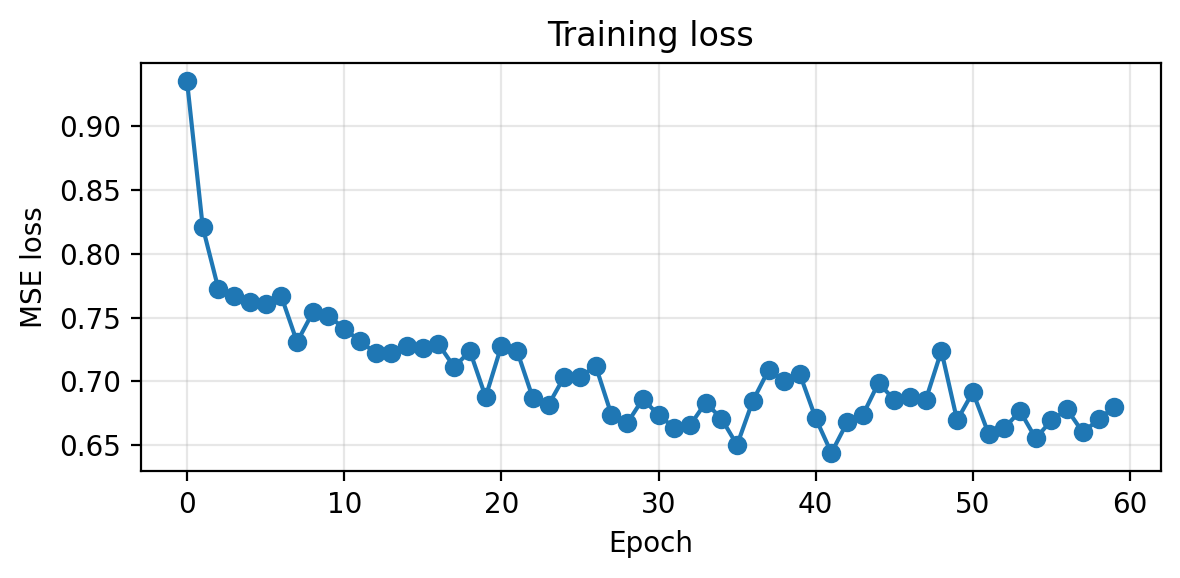

In [12]:
torch.manual_seed(0)

dataset_name = "3gaussians"
num_samples = 5000
batch_size = 256
train_tensor = get_1d_data(dataset_name, n_samples=num_samples)
train_dataset = torch.utils.data.TensorDataset(train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

time_dim = 32
hidden_dim = 128
data_dim = train_tensor.shape[1]
model = MLP(data_dim=data_dim, time_dim=time_dim, hidden_dim=hidden_dim, output_dim=1).to(device)
diffusion = DDPM1D(model, device=device, num_timesteps=200, beta_start=1e-4, beta_end=0.02).to(device)

optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-3)
num_epochs = 60
loss_history = []

for epoch in range(1, num_epochs + 1):
    diffusion.train()
    epoch_losses = []
    for (batch,) in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False):
        batch = batch.to(device)
        loss = diffusion.loss_fn(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    avg_loss = np.mean(epoch_losses)
    loss_history.append(avg_loss)
    if epoch % 10 == 0 or epoch == 1 or epoch == num_epochs:
        print(f"Epoch {epoch:02d} | loss = {avg_loss:.4f}")

plt.figure(figsize=(6, 3))
plt.plot(loss_history, marker='o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Visualize Samples

Visualize your learned distributions and compare them with the ground truth. I have left my visualization results for you as reference.

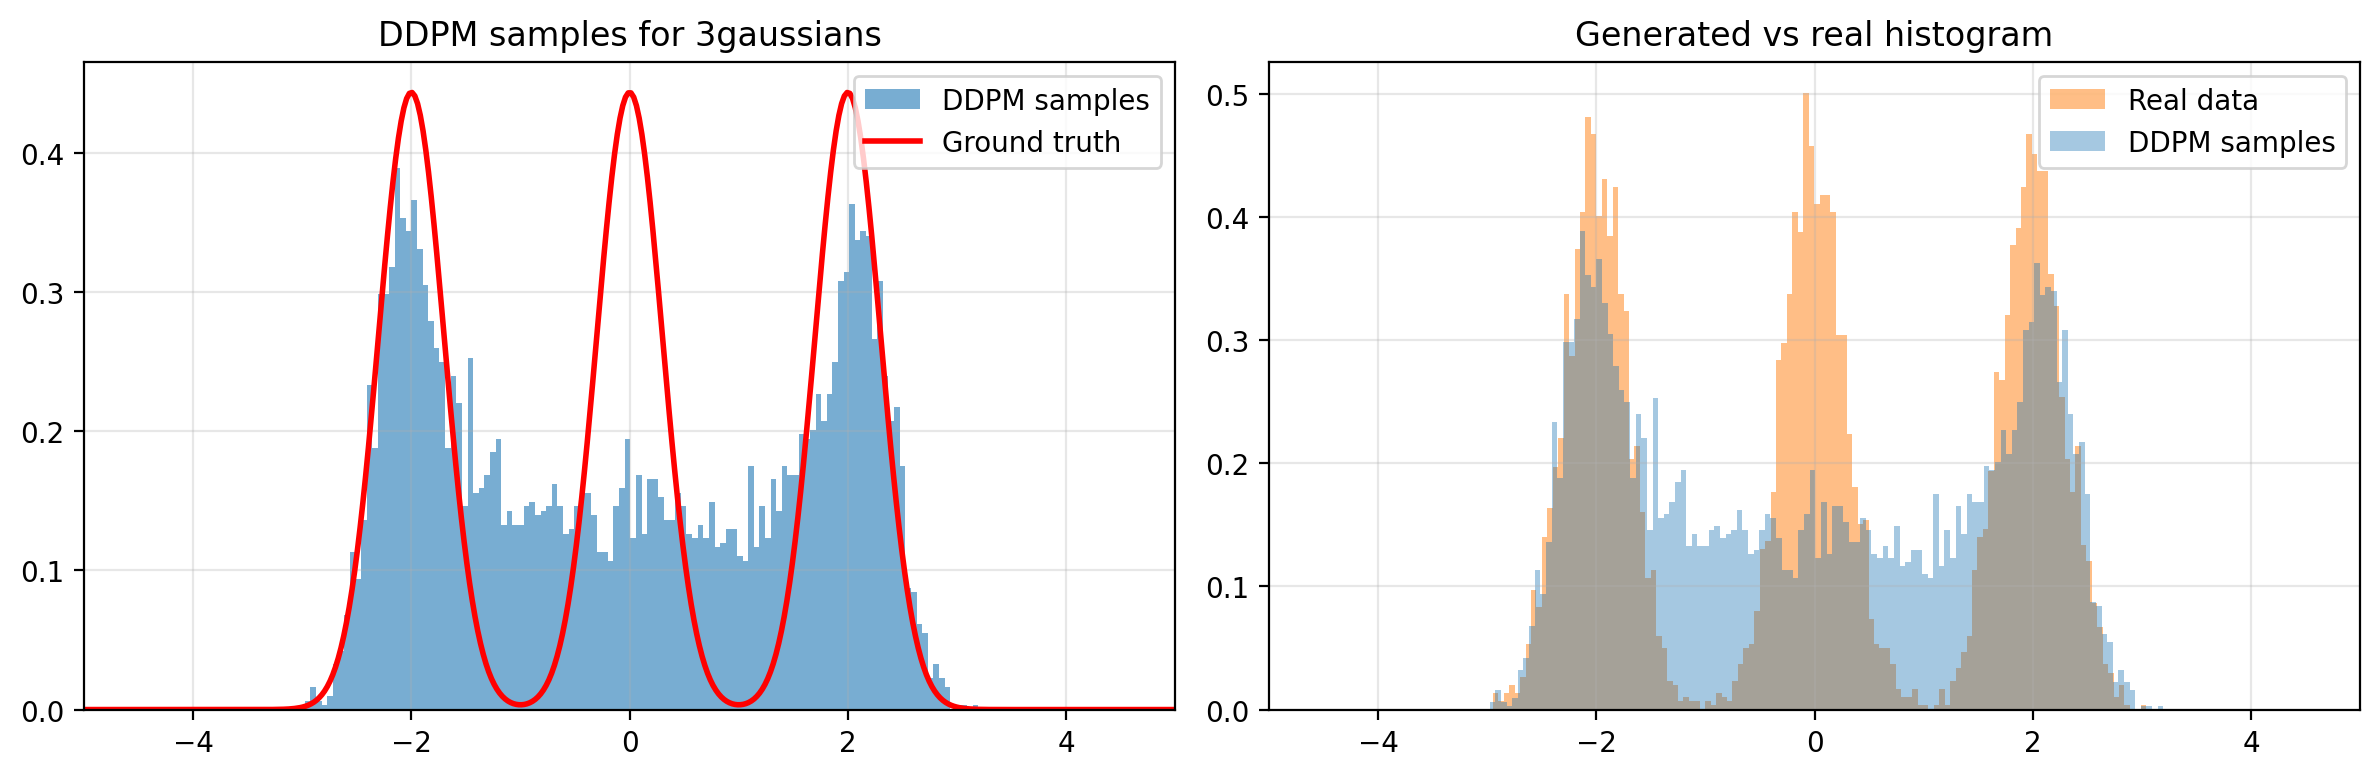

In [13]:
n_vis_samples = 6000

with torch.inference_mode():
    diffusion.eval()
    samples = diffusion.inference(sample_shape=(1,), num_samples=n_vis_samples)

samples = samples.view(-1).cpu().numpy()
real_samples = get_1d_data(dataset_name, n_samples=n_vis_samples).numpy().flatten()
x_line = np.linspace(-5, 5, 400)
gt_density = get_ground_truth_density(dataset_name, x_line)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(samples, bins=120, density=True, alpha=0.6, label='DDPM samples')
axes[0].plot(x_line, gt_density, 'r-', linewidth=2, label='Ground truth')
axes[0].set_title(f"DDPM samples for {dataset_name}")
axes[0].set_xlim(-5, 5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(real_samples, bins=120, density=True, alpha=0.5, label='Real data', color='tab:orange')
axes[1].hist(samples, bins=120, density=True, alpha=0.4, label='DDPM samples', color='tab:blue')
axes[1].set_title("Generated vs real histogram")
axes[1].set_xlim(-5, 5)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Visualize Sampling Trajectories

Besides visualizing the final results, you can also visualize the entire sampling trajectory in order to get a better understanding of the process. Here I also left you my visualization results as an example.

In [14]:
def plot_trajectory(trajectory, title, n_points=1000, n_steps_show=10, dataset_name=None):
    """Plot sampling trajectory."""
    n_total_steps = len(trajectory)
    step_indices = np.linspace(0, n_total_steps-1, n_steps_show, dtype=int)
    
    fig, axes = plt.subplots(1, n_steps_show, figsize=(2*n_steps_show, 3))
    
    # Prepare ground truth for final step if dataset name provided
    if dataset_name is not None:
        x_line = np.linspace(-5, 5, 300)
        gt_density = get_ground_truth_density(dataset_name, x_line)
    
    for ax, step_idx in zip(axes, step_indices):
        points = trajectory[step_idx][:n_points]
        ax.hist(points.numpy(), bins=50, density=True, alpha=0.7)
        
        # Overlay ground truth on final step
        if dataset_name is not None and step_idx == step_indices[-1]:
            ax.plot(x_line, gt_density, 'r-', linewidth=2, alpha=0.8)
        
        ax.set_xlim(-5, 5)
        ax.set_ylim(0, 1.2)
        ax.set_title(f't={step_idx}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        if ax == axes[0]:
            ax.set_ylabel('Density', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

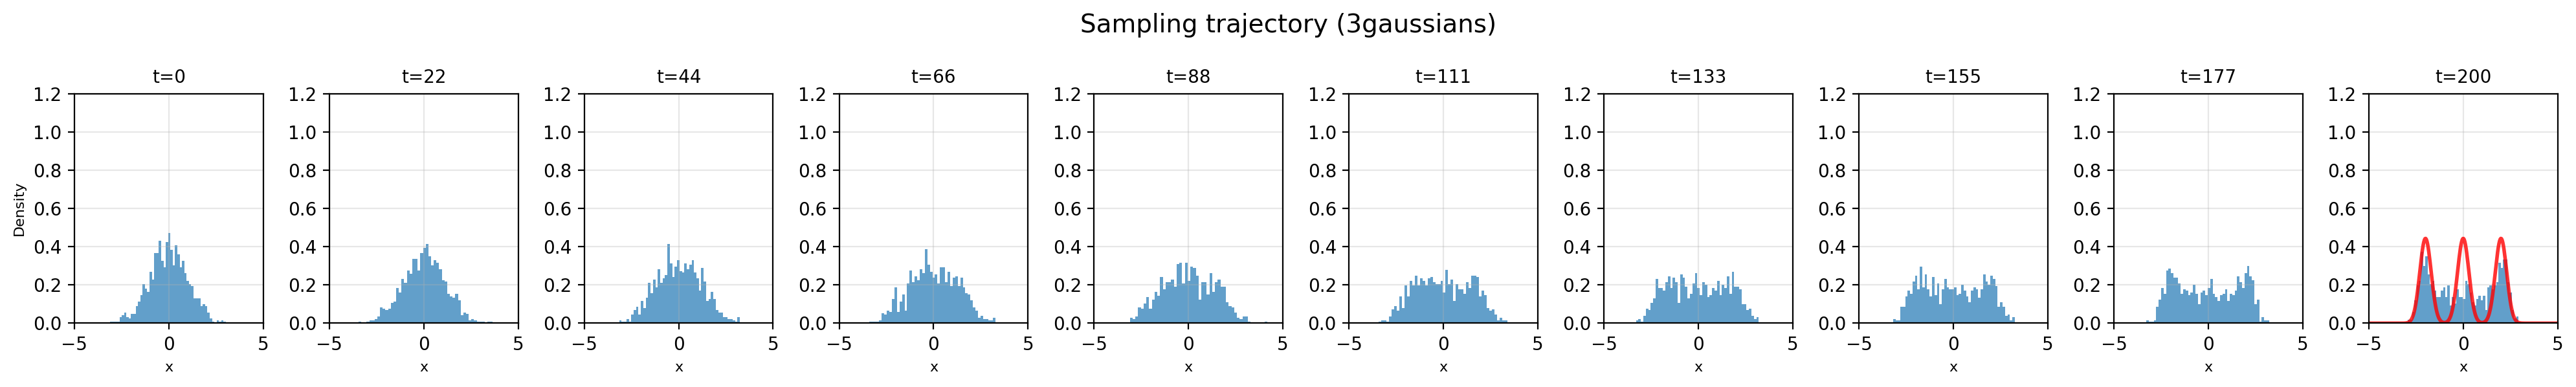

In [15]:
torch.manual_seed(42)

num_traj_points = 4000
sample_shape = (1,)

trajectory = []
with torch.inference_mode():
    diffusion.eval()
    x = torch.randn((num_traj_points, *sample_shape), device=device)
    trajectory.append(x.detach().cpu())

    for i in reversed(range(diffusion.num_timesteps)):
        t = torch.full((num_traj_points,), i, device=device, dtype=torch.long)
        pred_noise = diffusion.model(x, t)
        view_shape = (num_traj_points,) + (1,) * (x.dim() - 1)
        a_t = diffusion.alphas[t].view(view_shape)
        a_cp_t = diffusion.alphas_cumprod[t].view(view_shape)
        beta_t = diffusion.betas[t].view(view_shape)
        coeff = (1 - a_t) / torch.sqrt(1 - a_cp_t)
        mean = (1.0 / torch.sqrt(a_t)) * (x - coeff * pred_noise)

        if i > 0:
            noise = torch.randn_like(x)
            x = mean + torch.sqrt(beta_t) * noise
        else:
            x = mean

        trajectory.append(x.detach().cpu())

plot_trajectory(
    trajectory,
    title=f"Sampling trajectory ({dataset_name})",
    dataset_name=dataset_name,
    n_steps_show=10,
)
